<a href="https://colab.research.google.com/github/FernandoBRdgz/inteligencia_artificial/blob/main/representaciones_latentes/introducci%C3%B3n_a_autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introducción

Un autocodificador o *autoencoder* es un tipo específico de red neuronal que está diseñado principalmente para codificar la entrada en una representación comprimida y significativa para luego decodificarla de manera que la entrada reconstruida sea lo más similar posible a la original. Un Autoencoder es una arquitectura de cuello de botella que convierte una entrada de alta dimensión en un vector latente de baja dimensión (codificador) y luego realiza una reconstrucción de la entrada con este mismo vector latente (el decodificador).

En este *notebook* se comparten un par de ejemplos con Autoencoders. El primero es un ejemplo con datos estructurados y el segundo con imágenes.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds

#### Ejemplo #1

Primero se crea un conjunto de datos sintéticos para que actúe como entrada para el autocodificador con la siguiente función.

In [2]:
def generate_data(m):
    """Traza m puntos aleatorios en un plano 3D"""
    angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
    data = np.empty((m, 3))
    data[:,0] = np.cos(angles) + np.sin(angles)/2 + 0.1 * np.random.rand(m)/2
    data[:,1] = np.sin(angles) * 0.7 + 0.1 * np.random.rand(m) / 2
    data[:,2] = data[:,0] * 0.1 + data[:,1] * 0.3 + 0.1 * np.random.rand(m)

    return data

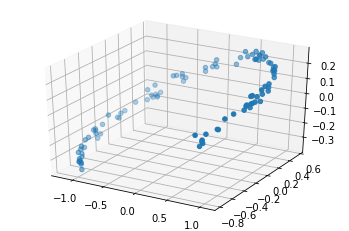

In [4]:
X_train = generate_data(100)
X_train = X_train - X_train.mean(axis=0, keepdims=0)

# Vista previa de los datos
ax = plt.axes(projection="3d")
ax.scatter3D(X_train[:, 0], X_train[:, 1], X_train[:, 2], cmap="Blues");

### Construcción del modelo

In [6]:
from tensorflow.keras.models import Sequential

In [7]:
encoder = Sequential([tf.keras.layers.Dense(2, input_shape=[3])])
decoder = Sequential([tf.keras.layers.Dense(3, input_shape=[2])])

autoencoder = Sequential([encoder, decoder])

In [9]:
autoencoder.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(learning_rate=0.1))

In [10]:
%%time
history = autoencoder.fit(X_train, X_train, epochs=200)

Epoch 1/200
4/4 [==============================] - 2s 10ms/step - loss: 0.1876
Epoch 2/200
4/4 [==============================] - 0s 7ms/step - loss: 0.1398
Epoch 3/200
4/4 [==============================] - 0s 23ms/step - loss: 0.1195
Epoch 4/200
4/4 [==============================] - 0s 7ms/step - loss: 0.1037
Epoch 5/200
4/4 [==============================] - 0s 21ms/step - loss: 0.0925
Epoch 6/200
4/4 [==============================] - 0s 8ms/step - loss: 0.0825
Epoch 7/200
4/4 [==============================] - 0s 9ms/step - loss: 0.0763
Epoch 8/200
4/4 [==============================] - 0s 8ms/step - loss: 0.0705
Epoch 9/200
4/4 [==============================] - 0s 10ms/step - loss: 0.0668
Epoch 10/200
4/4 [==============================] - 0s 13ms/step - loss: 0.0635
Epoch 11/200
4/4 [==============================] - 0s 13ms/step - loss: 0.0604
Epoch 12/200
4/4 [==============================] - 0s 14ms/step - loss: 0.0578
Epoch 13/200
4/4 [==============================] - 0s

### Codificador (Encoder)

Como se mencionó, se puede usar el codificador para comprimir la entrada a dos dimensiones.

In [12]:
# Codificar los datos
codings = encoder.predict(X_train)

# Muestra los vectores de entrada-salida del codificador
print(f'[INFO] Vector de entrada: {X_train[0]}')
print(f'[INFO] Vector codificado: {codings[0]}')

4/4 [==============================] - 0s 3ms/step
[INFO] Vector de entrada: [-0.15167821  0.4062239   0.12138062]
[INFO] Vector codificado: [-0.3292307   0.34482718]


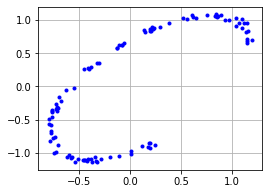

In [13]:
# Trazar todas las salidas del codificador
fig = plt.figure(figsize=(4,3))
plt.plot(codings[:, 0], codings[:, 1], 'b.')
plt.xlabel("", fontsize=18)
plt.ylabel("", fontsize=18, rotation=0)
plt.grid(True)
plt.show()

### Decodificador (Decoder)

El decodificador intenta reconstruir la entrada original. Vea las salidas a continuación. Aunque no es perfecto, sigue la forma general de la entrada original.

In [16]:
# Decodificar la salida del codificador
decodings = decoder.predict(codings)

# Muestra la entrada y salida del codificador y decodificador
print(f'[INFO] Observación de entrada: {X_train[0]}')
print(f'[INFO] Vector codificado: {codings[0]}')
print(f'[INFO] Vector decodificado: {decodings[0]}')

4/4 [==============================] - 0s 4ms/step
[INFO] Observación de entrada: [-0.15167821  0.4062239   0.12138062]
[INFO] Vector codificado: [-0.3292307   0.34482718]
[INFO] Vector decodificado: [-0.14105693  0.41811258  0.11193671]


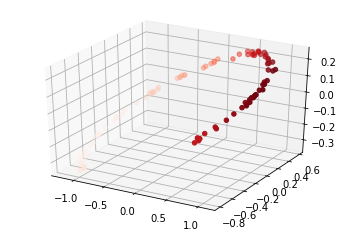

In [17]:
# Trazar la salida del decodificador

ax = plt.axes(projection='3d')
ax.scatter3D(decodings[:, 0], decodings[:, 1], decodings[:, 2], c=decodings[:, 0], cmap="Reds");

#### Ejemplo #2

Se carga el conjunto de datos MNIST de TFDS particionado en conjuntos de entrenamiento y prueba. Primero se define una función de preprocesamiento para normalizar y aplanar las imágenes. Dado que se entrena un auto-codificador, devolverá dos veces la misma imagen porque los datos de entrada también serán la viariable objetivo o la etiqueta durante el entrenamiento.

In [18]:
def map_image(image, label):
    # Normaliza y aplana las imágenes. Devuelve la misma imagen tanto como entrada como salida (etiqueta)
    image = tf.cast(image, dtype=tf.float32)
    image /= 255.0
    image = tf.reshape(image, shape=(784,))
    return image, image

In [19]:
batch_size = 128
buffer_size = 1024

In [20]:
train_dataset = tfds.load("mnist", as_supervised=True, split="train")
train_dataset = train_dataset.map(map_image)
train_dataset = train_dataset.shuffle(buffer_size).batch(batch_size).repeat()

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


In [21]:
test_dataset = tfds.load("mnist", as_supervised=True, split="test")
test_dataset = test_dataset.map(map_image)
test_dataset = test_dataset.batch(batch_size).repeat()

In [22]:
def simple_autoencoder(inputs):
    """Construye el codificador y decodificador usando capas densas"""
    encoder = tf.keras.layers.Dense(units=32, activation="relu")(inputs)
    decoder = tf.keras.layers.Dense(units=784, activation="sigmoid")(encoder)
    return encoder, decoder

In [23]:
inputs = tf.keras.layers.Input(shape=(784,))
encoder_output, decoder_output = simple_autoencoder(inputs)
encoder_model = tf.keras.Model(inputs=inputs, outputs=encoder_output)
autoencoder_model = tf.keras.Model(inputs=inputs, outputs=decoder_output)

In [24]:
autoencoder_model.compile(optimizer=tf.keras.optimizers.Adam(), loss="binary_crossentropy")

In [25]:
%%time
train_steps = 60000 // batch_size
simple_auto_history = autoencoder_model.fit(train_dataset, steps_per_epoch=train_steps, epochs=50)

Epoch 1/50
468/468 [==============================] - 10s 20ms/step - loss: 0.2276
Epoch 2/50
468/468 [==============================] - 7s 14ms/step - loss: 0.1411
Epoch 3/50
468/468 [==============================] - 6s 12ms/step - loss: 0.1191
Epoch 4/50
468/468 [==============================] - 7s 14ms/step - loss: 0.1080
Epoch 5/50
468/468 [==============================] - 6s 12ms/step - loss: 0.1015
Epoch 6/50
468/468 [==============================] - 6s 13ms/step - loss: 0.0978
Epoch 7/50
468/468 [==============================] - 6s 13ms/step - loss: 0.0959
Epoch 8/50
468/468 [==============================] - 6s 12ms/step - loss: 0.0950
Epoch 9/50
468/468 [==============================] - 7s 14ms/step - loss: 0.0945
Epoch 10/50
468/468 [==============================] - 5s 12ms/step - loss: 0.0941
Epoch 11/50
468/468 [==============================] - 8s 17ms/step - loss: 0.0939
Epoch 12/50
468/468 [==============================] - 6s 12ms/step - loss: 0.0938
Epoch 13/50


In [27]:
def display_one_row(disp_images, offset, shape=(28, 28)):
    # Muestra los resultados en una fila
    for idx, test_image in enumerate(disp_images):
        plt.subplot(3, 10, offset + idx + 1)
        plt.xticks([])
        plt.yticks([])
        test_image = np.reshape(test_image, shape)
        plt.imshow(test_image, cmap='gray')

In [31]:
def display_results(disp_input_images, disp_encoded, disp_predicted, enc_shape=(8, 4)):
    # Muestra los valores de salida de entrada, codificados y decodificados
    plt.figure(figsize=(15, 5))
    display_one_row(disp_input_images, 0, shape=(28, 28,))
    display_one_row(disp_encoded, 10, shape=enc_shape)
    display_one_row(disp_predicted, 20, shape=(28, 28,))

1/1 [==============================] - 0s 156ms/step


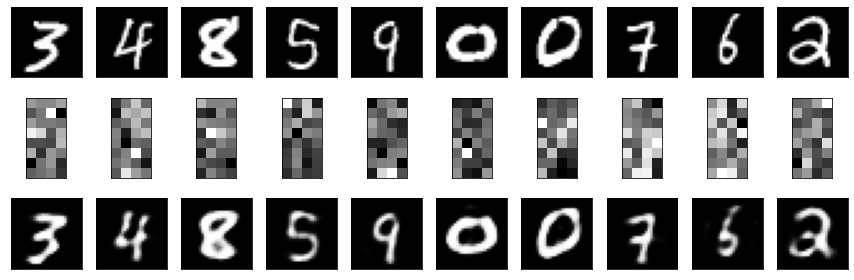

In [30]:
# Toma un batch del conjunto de datos
test_dataset = test_dataset.take(1)

output_samples = []
for input_image, image in tfds.as_numpy(test_dataset):
      output_samples = input_image

idxs = np.random.choice(batch_size, size=10)

# Obtiene la salida del codificador
encoded_predicted = encoder_model.predict(test_dataset)

# Obtiene una predicción para el lote de prueba
simple_predicted = autoencoder_model.predict(test_dataset)

# Muestra 10 observaciones, sus codificaciones y los valores decodificados
display_results(output_samples[idxs], encoded_predicted[idxs], simple_predicted[idxs])